### RNN Model

This notebook contains implementation of RNN model from the [Paper](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)

I will also continously use names dataset and mapping C for representing letters.

In [1]:
import torch
import torch.nn.functional as f
from dataclasses import dataclass
from typing import Tuple, List, Callable
from torch.utils.data import Dataset, DataLoader

@dataclass
class NetworkConfig:
    c_embedding: int = 50 # C.shape --> 27 X 20
    vocab_size: int = 27
    batch_size: int = 512
    input_weights: int = 1000# Wx.shape --> 20 x 1000; Wx @ x_t --> 512 x 1000
    tanh_gain: float = 5 / 3

@dataclass
class ForwardData:
    X: list
    Y: list
    t: int

In [2]:
class RNN_cell(torch.nn.Module):

    def __init__(self, config: NetworkConfig) -> None:
        """Initialize cell weights and biases tensors.

        Args:
            config (NetworkConfig): Dataclass containing network configuration.
        """
        super().__init__()
        self.Wxt = torch.nn.Linear(config.c_embedding, config.input_weights)
        self.Wat = torch.nn.Linear(config.input_weights, config.input_weights)
        torch.nn.init.kaiming_normal_(self.Wat.weight, nonlinearity='tanh') # samples from N(0, (25 / 9 * config.input_weights)) --> see the docs.
        torch.nn.init.kaiming_normal_(self.Wxt.weight, nonlinearity='tanh') # samples from N(0, (25 / 9 * config.c_embedding)) --> see the docs.

    
    def forward(self, xt: torch.Tensor, ht: torch.Tensor) -> torch.Tensor:
        """Compute forward pass of RNN Cell.

        Args:
            xt (torch.Tensor): Tensor containing input data.
            ht (torch.Tensor): Tensor containing previous context.

        Returns:
            torch.Tensor: Tensor with applied tanh nonlinearity.
        """
        #xt1 = xt (512x20) @ Wxt (20x200) + bx(1,200) -----> (512x200) \
        #                                                               | --> tanh((512,200))
        #h_t = h_t-1 (512x200) @ (200x200) + bh(1,200) ----> (512x200) /
        activation = self.Wxt(xt) + self.Wat(ht)
        return torch.tanh(activation)

class RNN(torch.nn.Module):

    def __init__(self, config: NetworkConfig = NetworkConfig):
        """
        Initialize RNN model with weights and biases.

        Args:
            config (NetworkConfig, optional): Class with model config. Defaults to NetworkConfig.
        """
        super().__init__()
        self.start = torch.nn.Parameter(torch.zeros(1, config.input_weights))
        self.cell = RNN_cell(config)
        self.x_embedding = torch.nn.Embedding(config.vocab_size, config.c_embedding)
        self.W_logits = torch.nn.Linear(config.input_weights, config.vocab_size)        # squash ex: (512x200) @ (200, 27) --> (512, 27)
        torch.nn.init.kaiming_normal_(self.W_logits.weight, nonlinearity='tanh', mode='fan_in')
    
    def forward(self, X: torch.Tensor, Y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute forward pass of the model.

        Args:
            data (Tuple[List, List]): Tuple containing list of training samples.
            t (int): Number of timestamps (length of batch sequence).
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple containing logits and loss tensors.
        """

        batch_size = X.shape[0]
        t = X.shape[1]

        #adjust "dummy" weights for timestamp 0 to fit with batch
        h_prev_context = self.start.expand((batch_size, NetworkConfig.input_weights))

        #create tensor with input data and targets with shape ------------------------------------> (config.batch_size, t)
        # xt = torch.tensor(data.X, requires_grad=False).reshape(batch_size, t)      # (config.batch_size, t)
        # targets = torch.tensor(data.Y, requires_grad=False).reshape(batch_size, t) # (config.batch_size, t)

        #list containing forward weights for every timestamp
        hidden_states = []                                              # [tensor_1.shape(512, 200), tensor_2.shape(512,200), ...., tensor_t.shape(512, 200)]
        for i in range(t):
            ht = self.cell(self.x_embedding(X[:, i]), h_prev_context)
            h_prev_context = ht                                         # (batch, 200)
            hidden_states.append(ht)
        
        #Stack all the weights into a tensor and calculate loss
        results = torch.stack(hidden_states, 1) # (config.batch_size, t, config.input_weights)
        logits = self.W_logits(results)         # (config.batch_size, t, config.vocab_size)
        loss = f.cross_entropy(logits.view(-1, NetworkConfig.vocab_size), Y.view(batch_size * t), ignore_index=-1)

        return logits, loss

    def predict(self, start_character: torch.Tensor, func: Callable[[int], str]) -> list[str]:
        """Predicts output based on input character.

        Args:
            start_character (torch.Tensor): Character to start with.
            func (Callable): Function to map int into string.

        Returns:
            list[str]: List with predicted characters.
        """
        self.eval()
        batch_size = 1
        h_prev_context = self.start.expand((batch_size, NetworkConfig.input_weights))
        xt = start_character.reshape(1, 1)

        results = [func[start_character.item()]]
        while xt.item():
            ht = self.cell(self.x_embedding(xt.reshape(1,1)), h_prev_context)
            h_prev_context = ht
            logits = self.W_logits(ht)
            probability = torch.softmax(logits.view(1, NetworkConfig.vocab_size), 1)
            result = torch.multinomial(probability, 1, replacement=True)
            results.append(func[result.item()])
            xt = result
        
        self.train(True)

        return results
    
    @torch.inference_mode()
    @staticmethod
    def validation_loop(model, val_data: DataLoader) -> float:
        val_loss = 0
        for i, (X, Y) in enumerate(val_data):
            X = X.to('cuda')
            Y = Y.to('cuda')
            logits, loss = model.forward(X, Y)
            val_loss += loss.item()
        return val_loss / (i + 1)

    @staticmethod
    def forward_data_to_tensor(f_data: ForwardData, device: str='cpu') -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Create torch.tensors from custom ForwardData class and send it to specified device. 

        Args:
            f_data (ForwardData): Data to be converted.
            device (str, optional): Device where tensor should be. Defaults to 'cpu'.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Tensors: X, Y, t casted to device.
        """
        batch_size = len(f_data.X)
        X = torch.tensor(f_data.X, requires_grad=False, device=device).reshape((batch_size, f_data.t))
        Y = torch.tensor(f_data.Y, requires_grad=False, device=device).reshape((batch_size, f_data.t))
        return X, Y, torch.tensor(f_data.t)

In [24]:
class RDataset(Dataset):

    def __init__(self, data: List[str], characters: List[str], max_len: int) -> None:
        self.words = data
        self.characters = characters
        self.max_word_len = max_len
        self.stoi = {char:val + 1 for val, char in enumerate(self.characters)}
        self.itos = {val:char for char, val in self.stoi.items()}
    
    def __len__(self):
        return len(self.words)
    
    def encode(self, word: str) -> torch.Tensor:
        return torch.tensor([self.stoi[ch] for ch in word], dtype=torch.long, requires_grad=False)
    
    def __getitem__(self, index):
        word = self.words[index]
        index = self.encode(word)
        #pad the examples
        x = torch.zeros(self.max_word_len + 1, dtype=torch.long, requires_grad=False)
        y = torch.zeros_like(x, requires_grad=False)
        x[1:len(index) + 1] = index
        y[:len(index)] = index
        y[len(index) + 1:] = -1
        return x, y


def _isascii(string: str) -> bool:
    for ch in string:
        if ord(ch) not in range(97, 123): return False
    return True

with open("../bigram/polish_names.txt", "r") as file:
    names = [name.rstrip("\n") for name in filter(lambda name: _isascii(name.rstrip("\n")), file.readlines())]

data = [name for name in names if len(name) in range(3, 16)]
perm = torch.randperm(len(data))
data = [data[index] for index in perm.tolist()]
characters, m_len = sorted(set(''.join(names))), len(max(data, key=lambda name: len(name)))

print(m_len, sorted(set(''.join(names))))

train_split = int(len(data) * 0.8)
val_split = int(len(data) * 0.9)
training_data = data[:train_split]
validation_data = data[train_split:val_split]
test_data = data[val_split:]

training_data = RDataset(training_data, characters, m_len)
# validation_data = RDataset(validation_data, characters, m_len)
# test_data = RDataset(test_data, characters, m_len)

training_loader = DataLoader(RDataset(training_data, characters, m_len), batch_size=NetworkConfig.batch_size)
validation_loader = DataLoader(RDataset(validation_data, characters, m_len), batch_size=NetworkConfig.batch_size)
test_loader = DataLoader(RDataset(test_data, characters, m_len), batch_size=NetworkConfig.batch_size)


15 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
# data = Dataset("../bigram/polish_names.txt")
# data.train_val_test_split()
# print(data)
model = RNN()
model.to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)
min_loss: float = 999.9999

model_train_loss, model_val_loss, epochs_counter = [], [], 1
best_weights = model.state_dict()

print(model, "\n", optimizer)

RNN(
  (cell): RNN_cell(
    (Wxt): Linear(in_features=50, out_features=1000, bias=True)
    (Wat): Linear(in_features=1000, out_features=1000, bias=True)
  )
  (x_embedding): Embedding(27, 50)
  (W_logits): Linear(in_features=1000, out_features=27, bias=True)
) 
 AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.01
)


In [14]:
for it in range(50):
    train_loss = []
    for i, (X, Y) in enumerate(training_loader):
        X = X.to('cuda')
        Y = Y.to('cuda')
        logits, loss = model.forward(X, Y)
        train_loss.append(loss)
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    print("\r", end='')
    if (validation_loss := RNN.validation_loop(model, validation_loader)) < min_loss:
        best_weights = model.state_dict()
        min_loss = validation_loss
    train_loss = torch.tensor(train_loss).mean().item()
    model_train_loss.append(train_loss)
    model_val_loss.append(validation_loss)
    print(f"Epoch {epochs_counter} | Train loss --> {train_loss:.4f} | Val loss --> {validation_loss:.4f} |", end='', flush=True)
    epochs_counter += 1

print(f"\nLoading weights for {min_loss=}")
model.load_state_dict(best_weights)

Epoch 200 | Train loss --> 1.9912 | Val loss --> 2.1373 |
Loading weights for min_loss=2.1373189555274115


<All keys matched successfully>

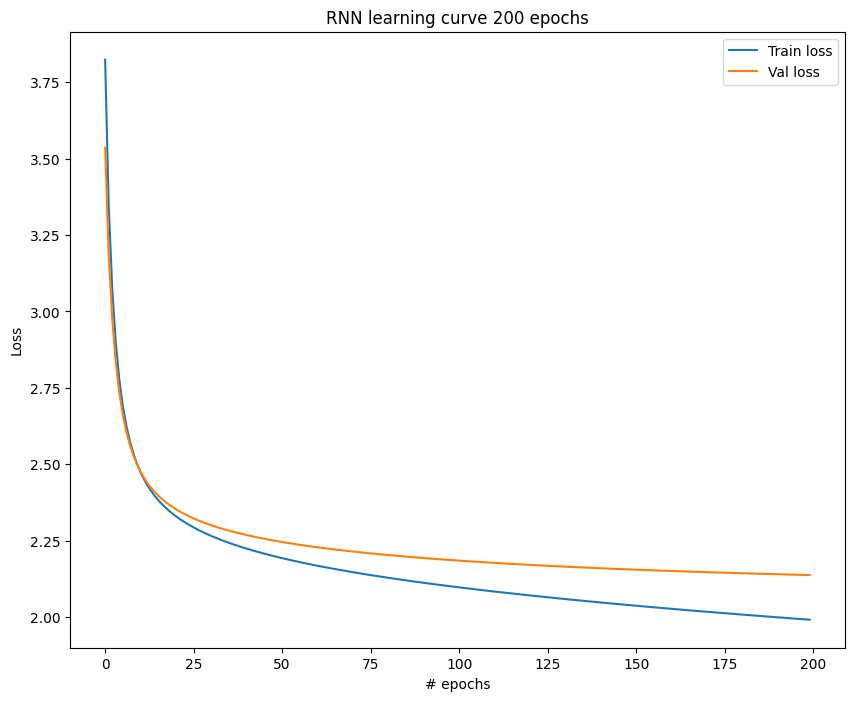

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.xlabel("# epochs")
plt.ylabel("Loss")
plt.title(f"RNN learning curve {epochs_counter - 1} epochs")
plt.plot(range(epochs_counter - 1), model_train_loss, label="Train loss")
plt.plot(range(epochs_counter - 1), model_val_loss, label="Val loss")
plt.legend()

In [16]:
print(f"Test set loss: {RNN.validation_loop(model, test_loader):.4f}")

Test set loss: 2.1427


In [33]:
torch.save(model.state_dict(), "./model.pt")

In [8]:
t_rnn = torch.nn.RNN(batch_first=True,
                     input_size=NetworkConfig.c_embedding,
                     hidden_size=NetworkConfig.input_weights)

t_optimizer = torch.optim.AdamW(t_rnn.parameters(), lr=0.0001, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)
t_embedding = torch.nn.Embedding(NetworkConfig.vocab_size, NetworkConfig.c_embedding ,device='cuda')
t_logits = torch.nn.Linear(NetworkConfig.input_weights, NetworkConfig.vocab_size, device='cuda')
t_m_loss: float = 999.99
t_m_weights = t_rnn.state_dict()
t_rnn.to('cuda')

RNN(50, 1000, batch_first=True)

In [12]:
for it in range(50):
    for i, (X_t, Y_t) in enumerate(training_loader): 
        X_t = X_t.to('cuda')
        Y_t = Y_t.to('cuda')

        X_t = t_embedding(X_t)
        h_0 = torch.zeros((1, X_t.shape[0], NetworkConfig.input_weights), device='cuda')
        output, hidden = t_rnn(X_t, h_0)

        #done only for excersise, normally would use nn.CrossEntropyLoss
        logits = t_logits(output)
        loss = f.cross_entropy(logits.view(-1, NetworkConfig.vocab_size), Y_t.view(-1), ignore_index=-1)
        t_rnn.zero_grad(set_to_none=True)
        loss.backward()
        t_optimizer.step()

    
    t_rnn.eval()
    losses_v = []
    for j, (X_val, Y_val) in enumerate(validation_loader):
        X_val = X_val.to('cuda')
        Y_val = Y_val.to('cuda')

        X_val = t_embedding(X_val)
        h_0_val = torch.zeros((1, X_val.shape[0], NetworkConfig.input_weights), device='cuda')

        output_v, hidden_v = t_rnn(X_val, h_0_val)

        #done only for excersise, normally would use nn.CrossEntropyLoss
        logits_v = t_logits(output_v)
        loss_v = f.cross_entropy(logits_v.view(-1, NetworkConfig.vocab_size), Y_val.view(-1), ignore_index=-1)

        losses_v.append(loss_v)

    losses_v = torch.tensor(losses_v).mean().item()
    if losses_v < t_m_loss:
        t_m_loss = losses_v
        t_m_weights = t_rnn.state_dict()
    print("\r", end='')
    print(f"Val loss after {it + 1} epochs --> {losses_v:.4f}\t Current {t_m_loss=:.4f}", end='', flush=True)
    t_rnn.train(True)

print(f"Loading weights for loss: {t_m_loss}")
t_rnn.load_state_dict(t_m_weights)

Val loss after 50 epochs --> 2.1834	 Current t_m_loss=2.1794Loading weights for loss: 2.1793947219848633


<All keys matched successfully>